In [305]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [306]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from typing import Union
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

import os 

while "notebooks" in os.getcwd():
    os.chdir("..")

from src.preprocessing.lstm.make_dataset import StockReturnsDataset, \
    StockPricesDataset, get_prices_features, normalize_features,\
    generate_sentiment_features

from src.preprocessing.finbert.get_news import get_news, \
    filter_news_with_name, save_company_news_df,\
    read_company_news_df

# LSTM Analysis with AMZN stock prices

## Prices

In [307]:
all_prices = pd.DataFrame([])

In [308]:
prices_df = yf.download(
    tickers= "AAPL",
    start="2020-12-30",
    end="2022-12-30",
)

[*********************100%***********************]  1 of 1 completed


In [627]:
universe = [
    "AMZN", 
    "AAPL", 
    "MSFT", 
    "TSLA",
    "META",
    "NFLX",
]
all_prices = []

for ticker in universe:
    prices_df = yf.download(
        tickers= ticker,
        start="2020-12-30",
        end="2022-12-30",
    )

    all_prices.append(get_prices_features(
        prices_df,
        ticker,
        lookback=3,
        pct_change= False
    ))


all_prices_df = pd.concat(all_prices)

all_prices_df["ticker"] = all_prices_df["ticker"]\
    .replace("META", "FB")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [628]:
prices_without_ticker = all_prices_df\
    .loc[:,all_prices_df.columns != 'ticker']

In [629]:
normalized_prices_df = normalize_features(
    prices_without_ticker
)

In [630]:
normalized_prices_df["ticker"] = all_prices_df["ticker"]

### Obtaining sentiment

In [631]:
universe = [
    "AMZN", 
    "AAPL", 
    "MSFT", 
    "TSLA",
    "FB",
    "NFLX",
]

sentiment_list = []

for ticker in tqdm(universe):
    sentiment = generate_sentiment_features(ticker,)
    sentiment["ticker"] = ticker
    sentiment_list.append(sentiment)

sentiment_df = pd.concat(sentiment_list)
sentiment_df.index = pd.to_datetime(sentiment_df.index)

 33%|███▎      | 2/6 [00:00<00:00, 16.32it/s]

100%|██████████| 6/6 [00:00<00:00, 20.94it/s]


In [632]:
sentiment_df.reset_index(inplace=True)
normalized_prices_df.reset_index(inplace=True)

In [633]:


features_df = pd.merge(
    normalized_prices_df,
    sentiment_df,
    left_on=["ticker", "Date"],
    right_on=["ticker", "date"],
    how = "left"
)\
    .set_index(["Date", "ticker"])

In [634]:
selected_columns = ~((features_df.columns == "index") | (features_df.columns == "date") )

In [641]:
feature_names = [i for i in range(1,3 + 1)]
feature_names.append("sentiment_count")


In [642]:
features_df

,,price,1,2,3,date,sentiment_count
Date,ticker,,,,,,
2021-01-05,AMZN,-0.740582,-0.745810,-0.737759,-0.735146,NaT,NaN
2021-01-06,AMZN,-0.753721,-0.740582,-0.749309,-0.739903,NaT,NaN
2021-01-07,AMZN,-0.749822,-0.753721,-0.744071,-0.751467,NaT,NaN
2021-01-08,AMZN,-0.746454,-0.749822,-0.757236,-0.746223,2021-01-08,0.00
2021-01-11,AMZN,-0.757684,-0.746454,-0.753329,-0.759404,2021-01-11,0.00
...,...,...,...,...,...,...,...
2022-12-22,NFLX,-0.291882,-0.291193,-0.325885,-0.327159,2022-12-22,-0.10
2022-12-23,NFLX,-0.301031,-0.291882,-0.293781,-0.327521,2022-12-23,0.25
2022-12-27,NFLX,-0.336416,-0.301031,-0.294471,-0.295378,2022-12-27,0.00


In [643]:
train_dates = features_df.index\
    .get_level_values("Date") < '2022-04'

test_dates = features_df.index\
    .get_level_values("Date") > '2022-04'

In [644]:
X_train = features_df\
    .loc[train_dates,selected_columns]\
    .fillna(0)

X_test = features_df\
    .loc[test_dates ,selected_columns]\
    .fillna(0)

In [645]:
y_train = features_df\
    .fillna(0)\
    .loc[train_dates, "price"]

y_test = features_df\
    .loc[test_dates, "price"]

In [646]:
X_train_numpy = X_train\
    .loc[:, feature_names]\
    .to_numpy()\
    .reshape((
        X_train.shape[0],
        X_train.shape[1] - 1,
        1
    ))

X_test_numpy = X_test\
    .loc[:, feature_names]\
    .to_numpy()\
    .reshape((
        X_test.shape[0],
        X_test.shape[1] - 1,
        1
    ))

In [647]:
y_train_numpy = y_train\
    .to_numpy()\
    .reshape(-1,1)

y_test_numpy = y_test\
    .to_numpy()\
    .reshape(-1,1)

In [648]:
X_train_tensor = torch\
    .from_numpy(X_train_numpy)\
    .type(torch.Tensor)

X_test_tensor = torch\
    .from_numpy(X_test_numpy)\
    .type(torch.Tensor)

In [649]:
y_train_tensor = torch\
    .from_numpy(y_train_numpy)\
    .type(torch.Tensor)

y_test_tensor = torch\
    .from_numpy(y_test_numpy)\
    .type(torch.Tensor)

In [650]:
dataset = StockPricesDataset(X_train_tensor, y_train_tensor)

dataloader = DataLoader(
    dataset,
    batch_size= 5,
    shuffle= True,
)

In [651]:
X_train_tensor.size(),\
y_train_tensor.size()

(torch.Size([1878, 4, 1]), torch.Size([1878, 1]))

## Building LSTM model

In [652]:
class LSTM(nn.Module):
    def __init__(self, 
                 input_dim: int, 
                 hidden_dim : int , 
                 num_layers : int , 
                 output_dim : int,
                 activation : callable = lambda x : x 
                ):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
            input_dim, 
            hidden_dim, 
            num_layers, 
            batch_first=True,
        )

        self.activation = activation

        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, 
                x: torch.Tensor):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.activation(out)
        out = self.fc(out[:, -1, :]) 
        return out

## Neural network training

In [654]:
# lookback = 100
input_dim = 1
hidden_dim = 1
num_layers = 1
output_dim = 1
num_epochs = 20

In [655]:
model = LSTM(
    input_dim,
    hidden_dim,
    num_layers,
    output_dim,
)

In [656]:
treinable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
treinable_params

18

In [657]:
loss_fn = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.02)

In [658]:
# hist = np.zeros(num_epochs)

for t in (range(num_epochs)):
    epoch_accuracy = []
    for X, y in tqdm(dataloader):
        y_train_pred = model(X)

        loss = loss_fn(y_train_pred, y)
        
        epoch_accuracy.append(loss.item())
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

    with torch.no_grad():
        y_test_pred = model(X_test_tensor)

        loss = loss_fn(y_test_pred, y_test_tensor)

        print(f"Epoch {t+1} error : {np.mean(epoch_accuracy)}")


  9%|▉         | 34/376 [00:00<00:01, 336.19it/s]

100%|██████████| 376/376 [00:00<00:00, 378.73it/s]


Epoch 1 error : 0.02622384494076114


100%|██████████| 376/376 [00:00<00:00, 387.09it/s]


Epoch 2 error : 0.006141320038218412


100%|██████████| 376/376 [00:00<00:00, 409.97it/s]


Epoch 3 error : 0.006163605257515496


100%|██████████| 376/376 [00:00<00:00, 421.08it/s]


Epoch 4 error : 0.004827179356652778


100%|██████████| 376/376 [00:00<00:00, 418.98it/s]


Epoch 5 error : 0.005057190361843281


100%|██████████| 376/376 [00:00<00:00, 419.99it/s]


Epoch 6 error : 0.005657997941640095


100%|██████████| 376/376 [00:00<00:00, 412.40it/s]


Epoch 7 error : 0.004813186504334419


100%|██████████| 376/376 [00:00<00:00, 416.94it/s]


Epoch 8 error : 0.005525048655746356


100%|██████████| 376/376 [00:00<00:00, 389.47it/s]


Epoch 9 error : 0.004603515895143302


100%|██████████| 376/376 [00:00<00:00, 383.97it/s]


Epoch 10 error : 0.004824224276006212


100%|██████████| 376/376 [00:00<00:00, 399.81it/s]


Epoch 11 error : 0.0045226343387726724


100%|██████████| 376/376 [00:00<00:00, 405.15it/s]


Epoch 12 error : 0.004224501654073507


100%|██████████| 376/376 [00:00<00:00, 417.49it/s]


Epoch 13 error : 0.004168418733396275


100%|██████████| 376/376 [00:00<00:00, 418.36it/s]


Epoch 14 error : 0.003980625548060646


100%|██████████| 376/376 [00:00<00:00, 405.36it/s]


Epoch 15 error : 0.0036821562983645213


100%|██████████| 376/376 [00:00<00:00, 412.63it/s]


Epoch 16 error : 0.003523989564200747


100%|██████████| 376/376 [00:00<00:00, 425.70it/s]


Epoch 17 error : 0.0035053261135351236


100%|██████████| 376/376 [00:00<00:00, 394.05it/s]


Epoch 18 error : 0.0032088805624890153


100%|██████████| 376/376 [00:00<00:00, 424.14it/s]


Epoch 19 error : 0.002507829176794714


100%|██████████| 376/376 [00:00<00:00, 395.99it/s]

Epoch 20 error : 0.002457746520015443


In [659]:
y_pred_test = model(X_test_tensor)\
    .detach()\
    .numpy()

y_pred_train = model(X_train_tensor)\
    .detach()\
    .numpy()

In [660]:
y_pred_test = pd.Series(
    y_pred_test\
        .reshape(-1),
    name = "price",
    index = y_test.index      
)

y_pred_train = pd.Series(
    y_pred_train\
        .reshape(-1),
    name = "price",
    index = y_train.index      
)


In [661]:
y_pred_train

Date        ticker
2021-01-05  AMZN     -0.721641
2021-01-06  AMZN     -0.724904
2021-01-07  AMZN     -0.730599
2021-01-08  AMZN     -0.732234
2021-01-11  AMZN     -0.733253
                        ...   
2022-03-25  NFLX      0.002405
2022-03-28  NFLX     -0.041178
2022-03-29  NFLX     -0.001622
2022-03-30  NFLX      0.019259
2022-03-31  NFLX      0.025235
Name: price, Length: 1878, dtype: float32

In [705]:
company_train = y_pred_train\
    .index\
    .get_level_values("ticker") == "TSLA"


company_test = y_pred_test\
    .index\
    .get_level_values("ticker") == "TSLA"

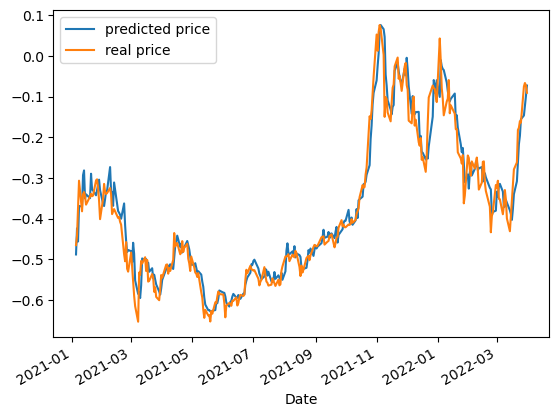

In [706]:
y_pred_train[company_train]\
    .reset_index(level=1)\
    ["price"]\
    .plot(
        label = "predicted price"
    )

y_train[company_train]\
    .reset_index(level=1)\
    ["price"]\
    .plot(
        label = "real price"
    )

plt.legend()

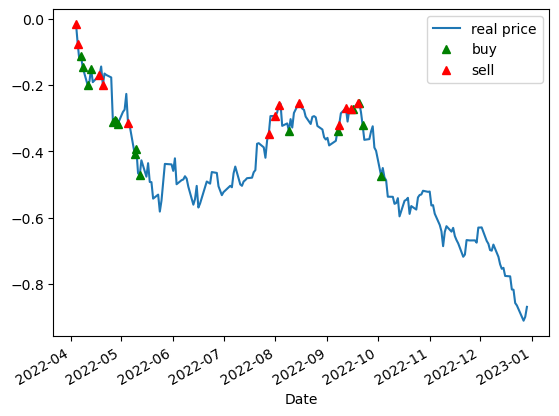

In [713]:
# y_test[company_test]\
#     .reset_index(level = "ticker")\
#     ["price"]\
#     .plot(
#         label = "predicted price"
#     )


y_test[company_test]\
    .reset_index(level= "ticker")\
    ["price"]\
    .plot(
        label = "real price",
        # color = "blue"
    )

y_test[(y_pred_test.pct_change() > 0.1 ) & (y_test.index.get_level_values("ticker") == "TSLA")]\
    .reset_index(level= "ticker")\
    ["price"]\
    .plot(
        label = "buy",
        marker = "^",
        linestyle = "None",
        color = "green"
    )

y_test[(y_pred_test.pct_change() < -0.1 ) & (y_test.index.get_level_values("ticker") == "TSLA")]\
    .reset_index(level= "ticker")\
    ["price"]\
    .plot(
        label = "sell",
        marker = "^",
        linestyle = "None",
        color = "red"
    )

plt.legend()

In [595]:
y_pred_test[company_test]

Date        ticker
2022-04-04  AAPL     -0.723368
2022-04-05  AAPL     -0.718864
2022-04-06  AAPL     -0.719369
2022-04-07  AAPL     -0.726107
2022-04-08  AAPL     -0.730015
                        ...   
2022-12-22  AAPL     -0.840502
2022-12-23  AAPL     -0.839414
2022-12-27  AAPL     -0.839077
2022-12-28  AAPL     -0.844648
2022-12-29  AAPL     -0.851409
Name: price, Length: 187, dtype: float32

In [45]:
prices_df = yf.download(
        tickers= "META",
        start="2020-12-30",
        end="2022-12-30",
    )

[*********************100%***********************]  1 of 1 completed


In [43]:
all_prices_df

,price,d-1,d-2,d-3,d-4,d-5,d-6,d-7,d-8,d-9,d-10,ticker
Date,,,,,,,,,,,,
2021-01-14,0.423449,0.460127,0.417110,0.410790,0.476174,0.456566,0.433864,0.510361,0.479926,0.547038,0.574646,AMZN
2021-01-15,0.401282,0.423449,0.460127,0.417110,0.410790,0.476174,0.456566,0.433864,0.510361,0.479926,0.547038,AMZN
2021-01-19,0.417043,0.401282,0.423449,0.460127,0.417110,0.410790,0.476174,0.456566,0.433864,0.510361,0.479926,AMZN
2021-01-20,0.553196,0.417043,0.401282,0.423449,0.460127,0.417110,0.410790,0.476174,0.456566,0.433864,0.510361,AMZN
2021-01-21,0.594828,0.553196,0.417043,0.401282,0.423449,0.460127,0.417110,0.410790,0.476174,0.456566,0.433864,AMZN
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-22,-0.891980,-0.810749,-0.809220,-0.728986,-0.726593,-0.677136,-0.682920,-0.655333,-0.609665,-0.535015,-0.572307,TSLA
2022-12-23,-0.906604,-0.891980,-0.810749,-0.809220,-0.728986,-0.726593,-0.677136,-0.682920,-0.655333,-0.609665,-0.535015,TSLA
2022-12-27,-1.000000,-0.906604,-0.891980,-0.810749,-0.809220,-0.728986,-0.726593,-0.677136,-0.682920,-0.655333,-0.609665,TSLA


In [4]:
prices_df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-12-30,167.050003,167.104996,164.123505,164.292496,164.292496,64186000
2020-12-31,163.750000,164.145996,162.059998,162.846497,162.846497,59144000
2021-01-04,163.500000,163.600006,157.201004,159.331497,159.331497,88228000
2021-01-05,158.300507,161.169006,158.253006,160.925507,160.925507,53110000
2021-01-06,157.324005,159.875504,156.557999,156.919006,156.919006,87896000
...,...,...,...,...,...,...
2022-12-22,85.519997,85.680000,82.250000,83.790001,83.790001,81431300
2022-12-23,83.250000,85.779999,82.930000,85.250000,85.250000,57433700
2022-12-27,84.970001,85.349998,83.000000,83.040001,83.040001,57284000


In [5]:
prices = prices_df[["Close"]]

In [6]:
scaler = MinMaxScaler(feature_range=(-1, 1))

In [7]:
scaled_prices = scaler\
    .fit_transform(prices)\
    .reshape(-1,1)

In [8]:
scaled_prices_df = pd.DataFrame(
    scaled_prices,
    index = prices.index, 
)\
    .rename(columns = {
        0: "price"
    })

In [9]:
lookback = 10
for i in range(1, lookback + 1):
    scaled_prices_df[f"d-{i}"] = scaled_prices_df\
        .price\
        .shift(i)
        
scaled_prices_df.dropna(inplace = True)

In [10]:
scaled_prices_df

,price,d-1,d-2,d-3,d-4,d-5,d-6,d-7,d-8,d-9,d-10
Date,,,,,,,,,,,
2021-01-14,0.423449,0.460127,0.417110,0.410790,0.476174,0.456566,0.433864,0.510361,0.479926,0.547038,0.574646
2021-01-15,0.401282,0.423449,0.460127,0.417110,0.410790,0.476174,0.456566,0.433864,0.510361,0.479926,0.547038
2021-01-19,0.417043,0.401282,0.423449,0.460127,0.417110,0.410790,0.476174,0.456566,0.433864,0.510361,0.479926
2021-01-20,0.553196,0.417043,0.401282,0.423449,0.460127,0.417110,0.410790,0.476174,0.456566,0.433864,0.510361
2021-01-21,0.594828,0.553196,0.417043,0.401282,0.423449,0.460127,0.417110,0.410790,0.476174,0.456566,0.433864
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-22,-0.962387,-0.905490,-0.935657,-0.940812,-0.884678,-0.873414,-0.813652,-0.796278,-0.833318,-0.861194,-0.837137
2022-12-23,-0.934511,-0.962387,-0.905490,-0.935657,-0.940812,-0.884678,-0.873414,-0.813652,-0.796278,-0.833318,-0.861194
2022-12-27,-0.976707,-0.934511,-0.962387,-0.905490,-0.935657,-0.940812,-0.884678,-0.873414,-0.813652,-0.796278,-0.833318


## Sentiment

In [11]:
news_df = read_company_news_df("amazon")

In [12]:
news_df["date"] = pd.to_datetime(news_df["date"]).dt.date